<div style="border-radius: 15px; border: 2px solid #2e8b57; padding: 20px; background-color: #b9fbc0; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); font-family: sans-serif;">

  <div style="text-align: center; margin-bottom: 20px;">
    <img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="300" alt="Logo FIUBA">
  </div>

  <h1 style="color: #2e8b57; text-align: center; text-shadow: 1px 1px 3px rgba(0,0,0,0.3); font-size: 28px; margin-bottom: 10px;">
    TRABAJO FINAL INTEGRADOR
  </h1>

  <div style="text-align: center;">
    <h2 style="color: #2e8b57; margin: 0; font-weight: normal;">VISIÓN POR COMPUTADORA II</h2>
    <h3 style="color: #2e8b57; margin-top: 5px; margin-bottom: 20px; font-weight: normal;">Chest CT-Scan images Dataset 2025</h3>
  </div>

  <hr style="border: none; height: 2px; background-color: #2e8b57; margin: 20px 0;">

  <div style="color: #004d40; font-size: 16px; font-weight: bold; margin-bottom: 5px;">ALUMNOS:</div>
  <ul style="color: #004d40; font-size: 16px; margin-top: 0; padding-left: 20px;">
    <li>Mauro Fabian Barquinero</li>
    <li>Juan Cruz Ojeda</li>
    <li>Mariano Campos</li>
    <li>Jose Luis Perez Galindo</li>
  </ul>

  <hr style="border: none; height: 1px; background-color: #2e8b57; margin: 20px 0;">

  <div style="text-align: center;">
    <a href="https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images" target="_blank"
       style="background-color: #2e8b57; color: white; padding: 10px 20px; text-decoration: none; border-radius: 8px; box-shadow: 1px 1px 4px rgba(0,0,0,0.3); font-weight: bold; display: inline-block;">
      ENLACE DATASET
    </a>
  </div>

</div>



c:\Users\Juan\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\matplotlylib\renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



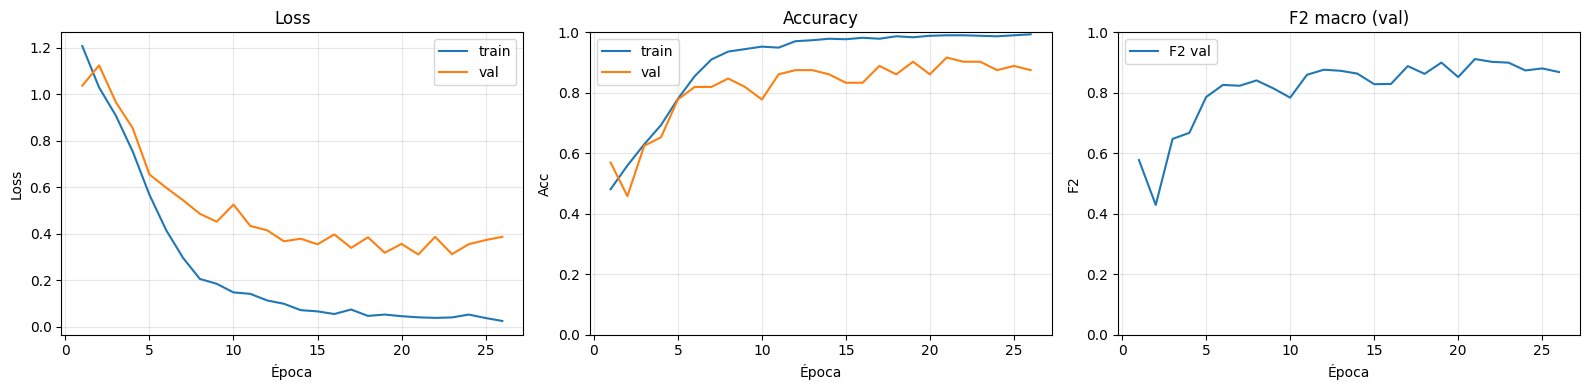

[Epoch 23/30] train_loss=0.0251 acc=0.993 | val_loss=0.3870 acc=0.875 F2=0.869 | best_F2=0.912 (epoch 18) | lr=7.50e-05

Reporte de clasificación (validación):

                         precision    recall  f1-score   support

         adenocarcinoma      0.909     0.870     0.889        23
   large.cell.carcinoma      0.905     0.905     0.905        21
                 normal      1.000     0.769     0.870        13
squamous.cell.carcinoma      0.737     0.933     0.824        15

               accuracy                          0.875        72
              macro avg      0.888     0.869     0.872        72
           weighted avg      0.888     0.875     0.876        72

Matriz de confusión (val):

pred→  adenocar  large.ce    normal  squamous
adenocar |       20        2        0        1
large.ce |        0       19        0        2
normal |        1        0       10        2
squamous |        1        0        0       14

Matriz de confusión normalizada por fila (val):

pred→ 

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
lr,███▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
train/acc,▁▂▃▄▅▆▇▇▇▇▇███████████████
train/loss,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▃▁▄▄▆▇▇▇▇▆▇▇▇▇▇▇█▇█▇███▇█▇
val/f2,▃▁▄▄▆▇▇▇▇▆▇▇▇▇▇▇█▇█▇███▇█▇
val/loss,▇█▇▆▄▃▃▃▂▃▂▂▁▂▁▂▁▂▁▁▁▂▁▁▂▂
epoch,26
lr,7e-05
phase,finetune
train/acc,0.99347


In [13]:
# =========================
# Standard library
# =========================
import csv
import os
import random
from collections import Counter
from pathlib import Path

# =========================
# Third-party (general utils)
# =========================
import numpy as np
import wandb

# =========================
# Visualization / notebook helpers
# =========================
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# =========================
# PyTorch ecosystem
# =========================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# =========================
# Image I/O
# =========================
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # permitir cargar imágenes truncadas

# =========================
# Scikit-learn metrics
# =========================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    ConfusionMatrixDisplay,
)
  

# ========================
# Parámetros
# ========================
TRAIN_DIR = "Data/train"
VAL_DIR   = "Data/valid"
RADIMAGENET_CKPT = "RadImageNet_pytorch/ResNet50.pt"

N_CLASSES = 4
BATCH_SIZE = 16
EPOCHS_WARMUP = 3
EPOCHS_FINE   = 30
LR_WARMUP = 1e-3
LR_FINE   = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0 # suavizado de etiquetas para evitar overfitting
USE_CLASS_WEIGHTS = False
SEED = 42

# Early Stopping
EARLY_STOP_PATIENCE = 5     # épocas sin mejora
EARLY_MIN_DELTA     = 1e-2  # mejora mínima en F2 para resetear paciencia
BEST_CKPT_PATH      = "best_radimagenet_resnet50_4cls.pt"

# ===== W&B =====

PROJECT = "entrenamientos_resnet"
ENTITY  = os.getenv("WANDB_ENTITY") 
PREFIX  = "experimento_"

def next_run_name():
    try:
        api = wandb.Api()
        path = f"{ENTITY}/{PROJECT}" if ENTITY else PROJECT
        runs = api.runs(path)
        nums = []
        for r in runs:
            if r.name and r.name.startswith(PREFIX):
                try:
                    nums.append(int(r.name.split("_")[-1]))
                except:
                    pass
        n = max(nums) + 1 if nums else 1
        return f"{PREFIX}{n}"
    except Exception:
        cfile = ".wandb_run_counter"
        n = 1
        if os.path.exists(cfile):
            try:
                n = int(open(cfile).read().strip()) + 1
            except:
                n = 1
        with open(cfile, "w") as f:
            f.write(str(n))
        return f"{PREFIX}{n}"


# Forzar modo online y definir API explícita
os.environ["WANDB_MODE"] = "online"
wandb.login(key="83405dd0b38b3d3e605ff65afa926afc9fa04994")


run = wandb.init(
    project=PROJECT,
    name=next_run_name(),
    config={
        "model": "resnet50",
        "batch_size": BATCH_SIZE,
        "epochs_warmup": EPOCHS_WARMUP,
        "epochs_fine": EPOCHS_FINE,
        "lr_warmup": LR_WARMUP,
        "lr_fine": LR_FINE,
        "weight_decay": WEIGHT_DECAY,
        "label_smoothing": LABEL_SMOOTHING,
        "use_class_weights": USE_CLASS_WEIGHTS,
        "seed": SEED,
    },
)

wandb.define_metric("epoch")
wandb.define_metric("*", step_metric="epoch")



# ========================
# Gráficas en vivo (loss, acc, F2)
# ========================


history = {
    "epoch":   [],
    "tr_loss": [],
    "va_loss": [],
    "tr_acc":  [],
    "va_acc":  [],
    "va_f2":   [],
}

def update_plots(hist, log_to_wandb=False, step=None):
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].plot(hist["epoch"], hist["tr_loss"], label="train")
    axes[0].plot(hist["epoch"], hist["va_loss"], label="val")
    axes[0].set_title("Loss"); axes[0].set_xlabel("Época"); axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3); axes[0].legend()

    axes[1].plot(hist["epoch"], hist["tr_acc"], label="train")
    axes[1].plot(hist["epoch"], hist["va_acc"], label="val")
    axes[1].set_title("Accuracy"); axes[1].set_xlabel("Época"); axes[1].set_ylabel("Acc")
    axes[1].set_ylim(0.0, 1.0); axes[1].grid(True, alpha=0.3); axes[1].legend()

    axes[2].plot(hist["epoch"], hist["va_f2"], label="F2 val")
    axes[2].set_title("F2 macro (val)"); axes[2].set_xlabel("Época"); axes[2].set_ylabel("F2")
    axes[2].set_ylim(0.0, 1.0); axes[2].grid(True, alpha=0.3); axes[2].legend()

    plt.tight_layout()
    if log_to_wandb:
        wandb.log({"fig/loss_acc_f2": fig}, step=step)
    display(fig)
    plt.close(fig)




# ========================
# Utilidades
# ========================


def log_confusion_figs(cm, class_names, prefix, step):
    
    # CM cruda
    fig1, ax1 = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)\
        .plot(ax=ax1, cmap="Blues", colorbar=True, values_format="d")
    ax1.set_title(f"Matriz de confusión - {prefix} (cruda)")
    plt.tight_layout()
    wandb.log({f"{prefix}/confusion_matrix_fig": fig1}, step=step)
    plt.close(fig1)

    # CM normalizada por fila
    cm_norm = cm.astype(np.float32) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    fig2, ax2 = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)\
        .plot(ax=ax2, cmap="Blues", colorbar=True, values_format=".2f")
    ax2.set_title(f"Matriz de confusión - {prefix} (normalizada)")
    plt.tight_layout()
    wandb.log({f"{prefix}/confusion_matrix_norm_fig": fig2}, step=step)
    plt.close(fig2)


def log_cm_and_report_to_wandb(y_true, y_pred, class_names, step):
    
    # Matriz de confusión interactiva
    wandb.log({
        "val/confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_true.tolist(),
            preds=y_pred.tolist(),
            class_names=class_names
        )
    }, step=step)

    # Reporte de clasificación como dict navegable
    rep_dict = classification_report(
        y_true, y_pred, target_names=class_names, digits=3, output_dict=True
    )
    wandb.log({"val/classification_report": rep_dict}, step=step)


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class EnsureRGB:
    """Asegurar modo RGB y descartar canal alfa si existe. Evitar transforms.Lambda por pickling."""
    def __call__(self, img: Image.Image) -> Image.Image:
        if img.mode == "RGBA":
            bg = Image.new("RGB", img.size, (255, 255, 255))
            bg.paste(img, mask=img.split()[3])
            return bg
        if img.mode != "RGB":
            return img.convert("RGB")
        return img


def log_epoch_details(y_true: np.ndarray, y_pred: np.ndarray, class_names):
    """Imprimir reporte por clase y matrices de confusión para validación."""
    print("Reporte de clasificación (validación):\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    labels = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("Matriz de confusión (val):\n")
    header = "pred→  " + "  ".join(f"{name[:8]:>8}" for name in class_names)
    print(header)
    for i, row in enumerate(cm):
        row_str = " ".join(f"{v:8d}" for v in row)
        print(f"{class_names[i][:8]:>6} | {row_str}")

    cm_norm = cm.astype(np.float32) / np.clip(cm.sum(axis=1, keepdims=True), a_min=1, a_max=None)
    print("\nMatriz de confusión normalizada por fila (val):\n")
    header_n = "pred→  " + "  ".join(f"{name[:8]:>8}" for name in class_names)
    print(header_n)
    for i, row in enumerate(cm_norm):
        row_str = " ".join(f"{v:8.2f}" for v in row)
        print(f"{class_names[i][:8]:>6} | {row_str}")
    #print()


def load_radimagenet_weights(model: nn.Module, ckpt_path: str) -> None:
    """Cargar pesos RadImageNet con remapeo de claves 'backbone.*' → ResNet torchvision."""
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"No encuentro el checkpoint: {ckpt_path}")

    obj = torch.load(ckpt_path, map_location="cpu")

    # 1) Extraer state_dict desde distintos formatos
    if isinstance(obj, dict):
        state = obj.get("state_dict", obj)
    elif hasattr(obj, "state_dict"):
        state = obj.state_dict()
    else:
        scripted = torch.jit.load(ckpt_path, map_location="cpu")
        state = scripted.state_dict()

    # 2) Normalizar prefijos comunes
    state = {k.replace("module.", "").replace("model.", ""): v for k, v in state.items()}

    # 3) Remapear claves 'backbone.X' al esquema de torchvision
    prefix_map = {
        "backbone.0": "conv1",
        "backbone.1": "bn1",
        "backbone.4": "layer1",
        "backbone.5": "layer2",
        "backbone.6": "layer3",
        "backbone.7": "layer4",
    }

    remapped = {}
    for k, v in state.items():
        if k.startswith("backbone."):
            parts = k.split(".")
            head = ".".join(parts[:2])     # p.ej. 'backbone.4'
            tail = ".".join(parts[2:])     # p.ej. '0.conv1.weight'
            base = prefix_map.get(head)
            if base is None:
                continue
            new_k = f"{base}.{tail}"
            remapped[new_k] = v
        else:
            if k.startswith(("fc.", "classifier.", "head.")):
                continue
            remapped[k] = v

    missing, unexpected = model.load_state_dict(remapped, strict=False)
    print("Faltantes:", missing, "Inesperadas:", unexpected, "\n")



# ========================
# Transforms
# ========================


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.01):
        self.mean, self.std = mean, std
    def __call__(self, t):
        return t + torch.randn_like(t) * self.std + self.mean

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    EnsureRGB(),
    transforms.Grayscale(num_output_channels=3),

    # --- Geométricas suaves ---
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10, fill=0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=0, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=0, fill=0
        )
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),  # ↓ sube o ponlo a 0.0 si L/R importa

    transforms.ToTensor(),

    # --- Ruido / blur / erasing ---
    transforms.RandomApply([AddGaussianNoise(std=0.01)], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.RandomErasing(p=0.1, scale=(0.05, 0.10), ratio=(0.5, 1.5)),

    transforms.Normalize(mean, std),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    EnsureRGB(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ========================
# Datasets y DataLoaders
# ========================
seed_everything(SEED)
train_dataset = ImageFolder(TRAIN_DIR, transform=train_tf)
val_dataset   = ImageFolder(VAL_DIR,   transform=val_tf)

num_workers = 0 if os.name == "nt" else min(4, os.cpu_count() or 0)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=(num_workers>0),
                          persistent_workers=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=(num_workers>0),
                          persistent_workers=False)

print(f"Tamaño train: {len(train_dataset)} | val: {len(val_dataset)} | workers: {num_workers}\n")

# ========================
# Modelo y carga de RadImageNet
# ========================
model = models.resnet50()  # arquitectura compatible con el checkpoint

# Cargar checkpoint RadImageNet antes de reemplazar la FC
load_radimagenet_weights(model, RADIMAGENET_CKPT)

# Reemplazar la capa final para N_CLASSES
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, N_CLASSES)
nn.init.normal_(model.fc.weight, 0, 0.01)
nn.init.zeros_(model.fc.bias)

# ========================
# Entrenamiento
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Pesos de clase opcionales (desbalance pequeño por defecto desactivado)
counts = Counter(train_dataset.targets)
cls_order = list(range(len(train_dataset.classes)))
if USE_CLASS_WEIGHTS:
    total = sum(counts.values())
    n_cls = len(train_dataset.classes)
    weights_np = np.array([total / (n_cls * counts[c]) for c in cls_order], dtype=np.float32)
    class_weights = torch.tensor(weights_np, device=device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

# Optimizadores y scheduler
optim_head = torch.optim.AdamW(model.fc.parameters(), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)
optim_all  = torch.optim.AdamW(model.parameters(), lr=LR_FINE,   weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_all, mode='max', factor=0.5, patience=2,
                              threshold=1e-3, min_lr=1e-6)

def train_one_epoch(loader, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total


def validate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    f2_macro = fbeta_score(y_true, y_pred, beta=2, average='macro')
    return total_loss / total, correct / total, f2_macro, y_true, y_pred

epoch_global = 0

# Fase 1: Warm-up
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

for epoch in range(EPOCHS_WARMUP):
    tr_loss, tr_acc = train_one_epoch(train_loader, optim_head)
    va_loss, va_acc, va_f2, y_true, y_pred = validate(val_loader)
    
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(val_dataset.classes))))
    log_confusion_figs(cm, val_dataset.classes, prefix="val", step=epoch_global)

    epoch_global += 1
    history["epoch"].append(epoch_global)
    history["tr_loss"].append(tr_loss)
    history["va_loss"].append(va_loss)
    history["tr_acc"].append(tr_acc)
    history["va_acc"].append(va_acc)
    history["va_f2"].append(va_f2)
    update_plots(history, log_to_wandb=True, step=epoch_global)
    wandb.log({
        "train/loss": tr_loss,
        "train/acc":  tr_acc,
        "val/loss":   va_loss,
        "val/acc":    va_acc,
        "val/f2":     va_f2,
        "lr":         optim_head.param_groups[0]["lr"],
        "phase":      "warmup",
        "epoch":      epoch_global,
    }, step=epoch_global)

    log_cm_and_report_to_wandb(y_true, y_pred, train_dataset.classes, step=epoch_global)

    print(f"[Warmup {epoch+1}/{EPOCHS_WARMUP}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} F2={va_f2:.3f}\n")
    log_epoch_details(y_true, y_pred, train_dataset.classes)

# Fase 2: fine-tuning completo
for p in model.parameters():
    p.requires_grad = True

best_f2 = float("-inf")
best_epoch = 0
epochs_no_improve = 0

for epoch in range(EPOCHS_FINE):
    # ---- contador de época coherente ----
    epoch_global += 1

    # ---- train ----
    tr_loss, tr_acc = train_one_epoch(train_loader, optim_all)

    # ---- validación ----
    va_loss, va_acc, va_f2, y_true, y_pred = validate(val_loader)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(val_dataset.classes))))
    log_confusion_figs(cm, val_dataset.classes, prefix="val", step=epoch_global)

    # ---- scheduler por métrica ----
    scheduler.step(va_f2)

    # ---- mejora y early stopping ----
    improved = (va_f2 - best_f2) > EARLY_MIN_DELTA
    if improved:
        best_f2 = va_f2
        best_epoch = epoch + 1
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_CKPT_PATH)
        
        # Subir a W&B como artefacto con alias y metadatos de linaje
        artifact = wandb.Artifact(
            name="checkpoint_best",        # nombre estable dentro del proyecto
            type="model",
            description="ResNet50 RadImageNet (mejor por F2)",
            metadata={
                "epoch_global": epoch_global,
                "epoch_finetune": (epoch + 1),
                "val_f2": float(va_f2),
                "source_run_id": run.id,
                "source_run_name": run.name
            }
        )
        artifact.add_file(BEST_CKPT_PATH)

        run.log_artifact(artifact, aliases=["best", f"run-{run.id}", run.name])
        
        flag = " *"
    else:
        epochs_no_improve += 1
        flag = ""

    # ---- tracking y plots ----
    history["epoch"].append(epoch_global)
    history["tr_loss"].append(tr_loss)
    history["va_loss"].append(va_loss)
    history["tr_acc"].append(tr_acc)
    history["va_acc"].append(va_acc)
    history["va_f2"].append(va_f2)
    update_plots(history, log_to_wandb=True, step=epoch_global)

    wandb.log({
        "train/loss": tr_loss,
        "train/acc":  tr_acc,
        "val/loss":   va_loss,
        "val/acc":    va_acc,
        "val/f2":     va_f2,
        "lr":         optim_all.param_groups[0]["lr"],
        "phase":      "finetune",
        "epoch":      epoch_global,
    }, step=epoch_global)

    log_cm_and_report_to_wandb(y_true, y_pred, val_dataset.classes, step=epoch_global)


    # ---- monitoreo de LR ----
    curr_lr = optim_all.param_groups[0]["lr"]

    print(f"[Epoch {epoch+1}/{EPOCHS_FINE}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} F2={va_f2:.3f} | "
          f"best_F2={best_f2:.3f} (epoch {best_epoch}) | lr={curr_lr:.2e}{flag}\n")
    log_epoch_details(y_true, y_pred, train_dataset.classes)

    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping activado en la época {epoch_global - EPOCHS_WARMUP} "
              f"por {epochs_no_improve} épocas sin mejora de F2 ≥ {EARLY_MIN_DELTA}.")
        break
    
run.finish()




In [14]:
# ========================
# Inferencia en conjunto de test (auto-vinculada a W&B)
# ========================


# --- Parámetros de inferencia
PROJECT   = "entrenamientos_resnet"
ENTITY    = os.getenv("WANDB_ENTITY")
TEST_DIR  = "Data/test"
CKPT_PATH = BEST_CKPT_PATH  # fallback local
BATCH_SZ  = BATCH_SIZE 
RUN_TAG   = "inference"

# --- W&B ---
os.environ["WANDB_MODE"] = "online"
wandb.login()  # usar la API del entorno/sesión

# --- Selección automática del ÚLTIMO experimento de entrenamiento
def get_latest_train_run():
    api = wandb.Api()
    path = f"{ENTITY}/{PROJECT}" if ENTITY else PROJECT
    runs = api.runs(path)
    # ordenar por creación descendente y filtrar job_type distinto de 'inference'
    runs = sorted(
        [r for r in runs if (getattr(r, "job_type", "") != "inference")],
        key=lambda r: r.created_at, reverse=True
    )
    return runs[0] if runs else None

latest = get_latest_train_run()

# --- Iniciar corrida de INFERENCIA y referenciar origen
src_name = latest.name if latest else "desconocido"
src_id   = latest.id   if latest else "desconocido"

run_inf = wandb.init(
    project=PROJECT,
    name=f"{src_name}_inferencia" if latest else "inferencia_sin_origen",
    job_type="inference",
    group=src_name if latest else None,
    tags=[RUN_TAG],
    config={
        "source_run_id":   src_id,
        "source_run_name": src_name,
        "test_dir":        TEST_DIR,
        "batch_size":      BATCH_SZ,
    }
)

# --- Intentar descargar el artefacto 'checkpoint_best:<alias>'
ckpt_path = None
if latest:
    try:
        alias = latest.name  # p.ej. "experimento_7"
        spec  = f"{ENTITY}/{PROJECT}/checkpoint_best:{alias}" if ENTITY else f"checkpoint_best:{alias}"
        art   = wandb.use_artifact(spec, type="model")
        model_dir = art.download()
        # elegir el primer archivo (el guardado por torch.save)
        for fn in os.listdir(model_dir):
            if fn.endswith((".pt", ".pth")):
                ckpt_path = os.path.join(model_dir, fn)
                break
        if ckpt_path is None:
            raise FileNotFoundError("No encuentro archivo .pt/.pth en el artefacto.")
        print(f"[W&B] Modelo recuperado del artefacto: {spec} -> {ckpt_path}")
    except Exception as e:
        print(f"[W&B] No pude recuperar el artefacto del último experimento ({e}). Uso fallback local: {CKPT_PATH}")

# --- Fallback local si falla W&B
if ckpt_path is None:
    ckpt_path = CKPT_PATH
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(
            f"No encuentro el checkpoint ni en W&B ni localmente. Revise alias del artefacto "
            f"('checkpoint_best:<experimento_N>') o genere {CKPT_PATH}."
        )

# --- DataLoader de test
test_dataset = ImageFolder(TEST_DIR, transform=val_tf)
num_workers_test = 0 if os.name == "nt" else min(4, os.cpu_count() or 0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SZ, shuffle=False,
                         num_workers=num_workers_test, pin_memory=(num_workers_test>0),
                         persistent_workers=False)

# --- Modelo y carga de checkpoint
model_test = models.resnet50()
in_features = model_test.fc.in_features
model_test.fc = torch.nn.Linear(in_features, N_CLASSES)
state = torch.load(ckpt_path, map_location="cpu")
model_test.load_state_dict(state, strict=True)
model_test = model_test.to(device)
model_test.eval()

# --- Inferencia
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model_test(images)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_prob = np.concatenate(all_probs, axis=0)
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# --- Métricas
labels_idx = list(range(len(test_dataset.classes)))
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(test_dataset.classes))))
log_confusion_figs(cm, test_dataset.classes, prefix="test", step=run_inf.step if hasattr(run_inf, "step") else None)

cm_norm = cm.astype(np.float32) / np.clip(cm.sum(axis=1, keepdims=True), a_min=1, a_max=None)
f2_macro = fbeta_score(y_true, y_pred, beta=2, average='macro')

print("Reporte de clasificación (test):\n")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=3))
print("Matriz de confusión (test):\n", cm)
print("Matriz de confusión normalizada por fila (test):\n", np.round(cm_norm, 3))
print(f"F2 macro (test): {f2_macro:.3f}")

# --- Log a W&B: F2, CM y reporte
wandb.log({"test/f2": f2_macro})
rep = classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=3, output_dict=True)
wandb.log({"test/classification_report": rep})

# --- Guardado de CSV local

OUT_CSV = "test_predictions.csv"
cls_names = test_dataset.classes
paths = [p[0] for p in test_dataset.samples]
header = ["filepath", "y_true_idx", "y_true", "y_pred_idx", "y_pred"] + [f"p_{c}" for c in cls_names]
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f); writer.writerow(header)
    for i, fp in enumerate(paths):
        row = [
            fp, int(y_true[i]), cls_names[y_true[i]],
            int(y_pred[i]), cls_names[y_pred[i]],
        ] + [float(y_prob[i, j]) for j in range(len(cls_names))]
        writer.writerow(row)
print(f"CSV de predicciones guardado en: {OUT_CSV}")

# --- Cerrar corrida de inferencia
run_inf.finish()


wandb: Downloading large artifact checkpoint_best:experimento_11, 90.02MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.6 (13.7MB/s)


[W&B] Modelo recuperado del artefacto: checkpoint_best:experimento_11 -> e:\IA\4_Bimestre\VpC2\artifacts\checkpoint_best-v80\best_radimagenet_resnet50_4cls.pt
Reporte de clasificación (test):

                         precision    recall  f1-score   support

         adenocarcinoma      0.935     0.725     0.817       120
   large.cell.carcinoma      0.806     0.980     0.885        51
                 normal      1.000     0.963     0.981        54
squamous.cell.carcinoma      0.778     0.933     0.848        90

               accuracy                          0.867       315
              macro avg      0.880     0.900     0.883       315
           weighted avg      0.881     0.867     0.865       315

Matriz de confusión (test):
 [[87  9  0 24]
 [ 1 50  0  0]
 [ 1  1 52  0]
 [ 4  2  0 84]]
Matriz de confusión normalizada por fila (test):
 [[0.725 0.075 0.    0.2  ]
 [0.02  0.98  0.    0.   ]
 [0.019 0.019 0.963 0.   ]
 [0.044 0.022 0.    0.933]]
F2 macro (test): 0.892
CSV de predi

test/f2,▁
test/f2,0.89165
